<a href="https://colab.research.google.com/github/Athar2410/Athar2410/blob/main/project_exhibition2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import SnowballStemmer

import os
import itertools
import cv2
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,  BatchNormalization, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers

import warnings
warnings.filterwarnings("ignore")

In [70]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importing Dataset

In [3]:
eyes = pd.read_csv('/content/full_df.csv')
eyes.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


In [4]:
eyes.columns


Index(['ID', 'Patient Age', 'Patient Sex', 'Left-Fundus', 'Right-Fundus',
       'Left-Diagnostic Keywords', 'Right-Diagnostic Keywords', 'N', 'D', 'G',
       'C', 'A', 'H', 'M', 'O', 'filepath', 'labels', 'target', 'filename'],
      dtype='object')

In [5]:
len(eyes)

6392

In [6]:
len(eyes[eyes.duplicated()])


0

In [7]:
eyes.isnull().sum()


,0
ID,0
Patient Age,0
Patient Sex,0
Left-Fundus,0
Right-Fundus,0
Left-Diagnostic Keywords,0
Right-Diagnostic Keywords,0
N,0
D,0
G,0


In [8]:
eyes['Left-Fundus'].nunique()


3358

In [9]:
photo_counts = eyes['Left-Fundus'].value_counts()

# Filter names that appear more than once
photo_more_than_once = photo_counts[photo_counts > 1].index.tolist()

print(len(photo_more_than_once))

photo_more_than_once[0]

3034


'4690_left.jpg'

In [10]:
eyes[eyes['Left-Fundus'] == '0_left.jpg']


,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
3194,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",0_left.jpg


In [11]:
eyes['labels'].value_counts()


,count
labels,
['N'],2873
['D'],1608
['O'],708
['C'],293
['G'],284
['A'],266
['M'],232
['H'],128


In [12]:
print(len(eyes[(eyes['labels'] == "['N']") & (eyes['N'] != 1)]))
print(len(eyes[(eyes['labels'] == "['D']") & (eyes['D'] != 1)]))
print(len(eyes[(eyes['labels'] == "['O']") & (eyes['O'] != 1)]))
print(len(eyes[(eyes['labels'] == "['C']") & (eyes['C'] != 1)]))
print(len(eyes[(eyes['labels'] == "['G']") & (eyes['G'] != 1)]))
print(len(eyes[(eyes['labels'] == "['A']") & (eyes['A'] != 1)]))
print(len(eyes[(eyes['labels'] == "['M']") & (eyes['M'] != 1)]))
print(len(eyes[(eyes['labels'] == "['H']") & (eyes['H'] != 1)]))

772
0
3
0
0
0
0
0


In [13]:
eyes.drop(columns=[ 'ID'] , inplace=True)

In [14]:
len(eyes[eyes['Patient Age'] == 1])

28

In [15]:
def update_labels(row):

    x = ''
    for col in eyes.columns:
        if row[col] == 1 and col != 'Patient Age':
            x = x + col
    row['labels'] = x
    return row

eyes = eyes.apply(update_labels, axis=1)

In [16]:
eyes['labels'].nunique()

37

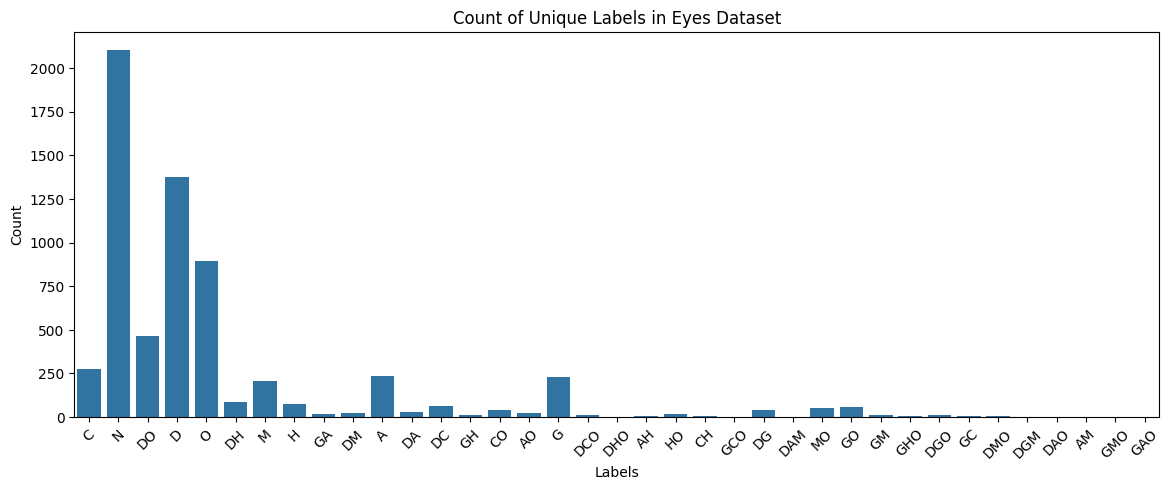

In [17]:
plt.figure(figsize=(14, 5))
sns.countplot(x='labels', data=eyes , orient='h')
plt.title('Count of Unique Labels in Eyes Dataset')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [18]:
eyes[eyes['Left-Diagnostic Keywords'] == 'low image quality']


,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
2547,45,Male,3935_left.jpg,3935_right.jpg,low image quality,mild nonproliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,D,"[0, 1, 0, 0, 0, 0, 0, 0]",3935_right.jpg
2606,71,Male,4007_left.jpg,4007_right.jpg,low image quality,mild nonproliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,D,"[0, 1, 0, 0, 0, 0, 0, 0]",4007_right.jpg
2744,48,Male,4169_left.jpg,4169_right.jpg,low image quality,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,D,"[0, 1, 0, 0, 0, 0, 0, 0]",4169_right.jpg
2854,51,Male,4290_left.jpg,4290_right.jpg,low image quality,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",4290_right.jpg
2989,62,Female,4442_left.jpg,4442_right.jpg,low image quality,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,D,"[0, 1, 0, 0, 0, 0, 0, 0]",4442_right.jpg
2994,50,Male,4448_left.jpg,4448_right.jpg,low image quality,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,D,"[0, 1, 0, 0, 0, 0, 0, 0]",4448_right.jpg
3053,67,Male,4522_left.jpg,4522_right.jpg,low image quality,severe nonproliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,D,"[0, 1, 0, 0, 0, 0, 0, 0]",4522_right.jpg


In [19]:
eyes[eyes['Left-Diagnostic Keywords'] == 'low image quality']


,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
2547,45,Male,3935_left.jpg,3935_right.jpg,low image quality,mild nonproliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,D,"[0, 1, 0, 0, 0, 0, 0, 0]",3935_right.jpg
2606,71,Male,4007_left.jpg,4007_right.jpg,low image quality,mild nonproliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,D,"[0, 1, 0, 0, 0, 0, 0, 0]",4007_right.jpg
2744,48,Male,4169_left.jpg,4169_right.jpg,low image quality,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,D,"[0, 1, 0, 0, 0, 0, 0, 0]",4169_right.jpg
2854,51,Male,4290_left.jpg,4290_right.jpg,low image quality,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",4290_right.jpg
2989,62,Female,4442_left.jpg,4442_right.jpg,low image quality,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,D,"[0, 1, 0, 0, 0, 0, 0, 0]",4442_right.jpg
2994,50,Male,4448_left.jpg,4448_right.jpg,low image quality,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,D,"[0, 1, 0, 0, 0, 0, 0, 0]",4448_right.jpg
3053,67,Male,4522_left.jpg,4522_right.jpg,low image quality,severe nonproliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,D,"[0, 1, 0, 0, 0, 0, 0, 0]",4522_right.jpg


In [20]:
eyes = eyes.loc[~(eyes['Left-Diagnostic Keywords'] == 'low image quality')]
eyes = eyes.loc[~(eyes['Right-Diagnostic Keywords'] == 'low image quality')]

In [21]:
print(len(eyes[(eyes['labels'] == "['N']") & (eyes['N'] != 1)]))
print(len(eyes[(eyes['labels'] == "['O']") & (eyes['O'] != 1)]))
eyes.head()

0
0


,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,C,"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,DO,"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,DO,"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,D,"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


In [22]:
photos_unique = eyes.drop_duplicates(subset='Left-Fundus', keep='first')
eyes = photos_unique
eyes.reset_index(drop=True,inplace=True)
len(eyes)

3340

In [23]:
eyes['Left-Diagnostic Keywords'].nunique()

194

In [24]:
eyes['Right-Diagnostic Keywords'].nunique()

204

In [25]:
eyes['Left-Diagnostic Keywords'].mode()

,Left-Diagnostic Keywords
0,normal fundus


In [26]:
eyes['Left-Diagnostic Keywords'].value_counts()

,count
Left-Diagnostic Keywords,
normal fundus,1433
moderate non proliferative retinopathy,359
mild nonproliferative retinopathy,217
cataract,135
pathological myopia,111
...,...
epiretinal membrane，epiretinal membrane，lens dust,1
moderate non proliferative retinopathy，myelinated nerve fibers，laser spot,1
glaucoma，mild nonproliferative retinopathy，macular pigmentation disorder,1


In [27]:
len(eyes[eyes['Left-Diagnostic Keywords'] == 'normal fundus'])

1433

In [28]:
eyes['Right-Diagnostic Keywords'].mode()

,Right-Diagnostic Keywords
0,normal fundus


In [29]:
len(eyes[eyes['Right-Diagnostic Keywords'] == 'normal fundus'])

1382

In [30]:
both_eyes_normal = eyes[
    (eyes['Right-Diagnostic Keywords'] == 'normal fundus') &
    (eyes['Left-Diagnostic Keywords'] == 'normal fundus')
]

both_eyes_normal.reset_index(inplace=True,drop=True)

len(both_eyes_normal)

1001

In [31]:
both_eyes_not_normal = eyes[
    (eyes['Right-Diagnostic Keywords'] != 'normal fundus') &
    (eyes['Left-Diagnostic Keywords'] != 'normal fundus')
]

both_eyes_not_normal.reset_index(inplace=True,drop=True)

len(both_eyes_not_normal)

1526

In [32]:
right_eye_normal = eyes[
    (eyes['Right-Diagnostic Keywords'] == 'normal fundus') &
    (eyes['Left-Diagnostic Keywords'] != 'normal fundus')
]

right_eye_normal.reset_index(inplace=True,drop=True)

len(right_eye_normal)

381

In [33]:
left_eye_normal = eyes[
    (eyes['Right-Diagnostic Keywords'] != 'normal fundus') &
    (eyes['Left-Diagnostic Keywords'] == 'normal fundus')
]

left_eye_normal.reset_index(inplace=True,drop=True)

len(left_eye_normal)

432

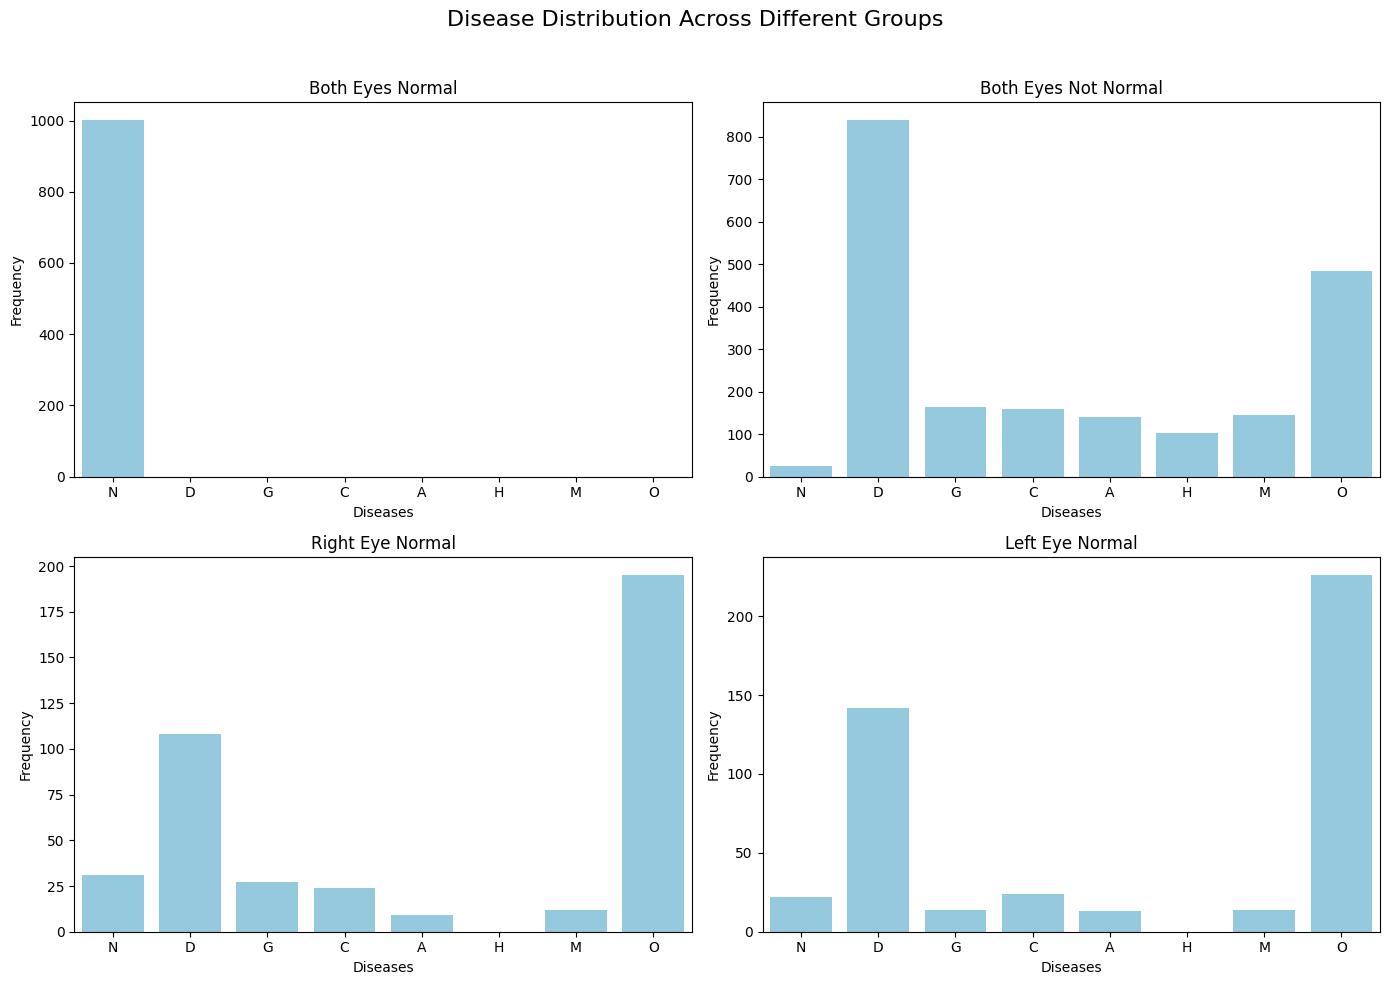

In [34]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Disease Distribution Across Different Groups', fontsize=16)

# Define titles for the subplots
titles = [
    'Both Eyes Normal',
    'Both Eyes Not Normal',
    'Right Eye Normal',
    'Left Eye Normal'
]

# Create a list of DataFrames
dataframes = [both_eyes_normal, both_eyes_not_normal, right_eye_normal, left_eye_normal]

# Loop through DataFrames and plot on subplots
for df, ax, title in zip(dataframes, axes.ravel(), titles):
    disease_columns = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
    disease_counts = df[disease_columns].sum()

    sns.barplot(x=disease_counts.index, y=disease_counts.values, color='skyblue', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Diseases')
    ax.set_ylabel('Frequency')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [35]:
len(both_eyes_normal)


1001

In [36]:
both_eyes_not_normal[both_eyes_not_normal['N'] == 1]


,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
987,70,Female,2357_left.jpg,2357_right.jpg,normal fundus，lens dust,normal fundus，lens dust,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2357_right.jpg
988,70,Female,2571_left.jpg,2571_right.jpg,lens dust，normal fundus,normal fundus，lens dust,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2571_right.jpg
989,59,Male,2580_left.jpg,2580_right.jpg,lens dust，normal fundus,normal fundus，lens dust,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2580_right.jpg
990,45,Male,2589_left.jpg,2589_right.jpg,lens dust，normal fundus,normal fundus，lens dust,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2589_right.jpg
991,67,Male,2598_left.jpg,2598_right.jpg,normal fundus，lens dust,normal fundus，lens dust,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2598_right.jpg
992,70,Female,2611_left.jpg,2611_right.jpg,lens dust，normal fundus,normal fundus，lens dust,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2611_right.jpg
993,67,Female,2719_left.jpg,2719_right.jpg,normal fundus，lens dust,normal fundus，lens dust,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2719_right.jpg
994,43,Male,2752_left.jpg,2752_right.jpg,lens dust，normal fundus,normal fundus，lens dust,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2752_right.jpg
995,62,Female,2893_left.jpg,2893_right.jpg,lens dust，normal fundus,normal fundus，lens dust,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2893_right.jpg
996,66,Female,2959_left.jpg,2959_right.jpg,lens dust，normal fundus,normal fundus，lens dust,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2959_right.jpg


In [37]:
filtered_df = both_eyes_not_normal[both_eyes_not_normal['N'] == 1]

both_eyes_normal = pd.concat(
    [both_eyes_normal[both_eyes_normal['N'].isin(filtered_df['N'])], filtered_df],
    axis=0, ignore_index=True
).drop_duplicates()

In [38]:
both_eyes_not_normal = both_eyes_not_normal.loc[~(both_eyes_not_normal['N'] == 1)]


In [39]:
right_eye_normal[right_eye_normal['N'] == 1]


,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
269,68,Male,2400_left.jpg,2400_right.jpg,lens dust，normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2400_right.jpg
270,33,Male,2483_left.jpg,2483_right.jpg,normal fundus，lens dust,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2483_right.jpg
271,50,Female,2486_left.jpg,2486_right.jpg,normal fundus，lens dust,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2486_right.jpg
272,68,Female,2495_left.jpg,2495_right.jpg,lens dust，normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2495_right.jpg
273,52,Female,2496_left.jpg,2496_right.jpg,lens dust，normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2496_right.jpg
274,72,Female,2509_left.jpg,2509_right.jpg,normal fundus，lens dust,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2509_right.jpg
275,62,Female,2566_left.jpg,2566_right.jpg,normal fundus，lens dust,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2566_right.jpg
276,34,Male,2629_left.jpg,2629_right.jpg,lens dust，normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2629_right.jpg
277,49,Female,2652_left.jpg,2652_right.jpg,normal fundus，lens dust,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2652_right.jpg
278,45,Female,2661_left.jpg,2661_right.jpg,normal fundus，lens dust,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2661_right.jpg


In [40]:
filtered_df = right_eye_normal[right_eye_normal['N'] == 1]

both_eyes_normal = pd.concat(
    [both_eyes_normal[both_eyes_normal['N'].isin(filtered_df['N'])], filtered_df],
    axis=0, ignore_index=True
).drop_duplicates()

In [41]:
right_eye_normal = right_eye_normal.loc[~(right_eye_normal['N'] == 1)]


In [42]:
left_eye_normal[left_eye_normal['N'] == 1]


,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
241,46,Female,2370_left.jpg,2370_right.jpg,normal fundus,normal fundus，lens dust,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2370_right.jpg
242,69,Male,2520_left.jpg,2520_right.jpg,normal fundus,normal fundus，lens dust,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2520_right.jpg
243,51,Male,2954_left.jpg,2954_right.jpg,normal fundus,normal fundus，lens dust,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2954_right.jpg
244,63,Female,3283_left.jpg,3283_right.jpg,normal fundus,normal fundus，lens dust,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",3283_right.jpg
412,51,Male,2377_left.jpg,2377_right.jpg,normal fundus,lens dust，normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2377_left.jpg
413,56,Male,2448_left.jpg,2448_right.jpg,normal fundus,lens dust，normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2448_left.jpg
414,39,Male,2515_left.jpg,2515_right.jpg,normal fundus,lens dust，normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2515_left.jpg
415,75,Male,2724_left.jpg,2724_right.jpg,normal fundus,lens dust，normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2724_left.jpg
416,66,Male,2727_left.jpg,2727_right.jpg,normal fundus,lens dust，normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2727_left.jpg
417,62,Female,2729_left.jpg,2729_right.jpg,normal fundus,lens dust，normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2729_left.jpg


In [43]:
filtered_df = left_eye_normal[left_eye_normal['N'] == 1]

both_eyes_normal = pd.concat(
    [both_eyes_normal[both_eyes_normal['N'].isin(filtered_df['N'])], filtered_df],
    axis=0, ignore_index=True
).drop_duplicates()

In [44]:
left_eye_normal = left_eye_normal.loc[~(left_eye_normal['N'] == 1)]


In [45]:
len(both_eyes_normal)


1079

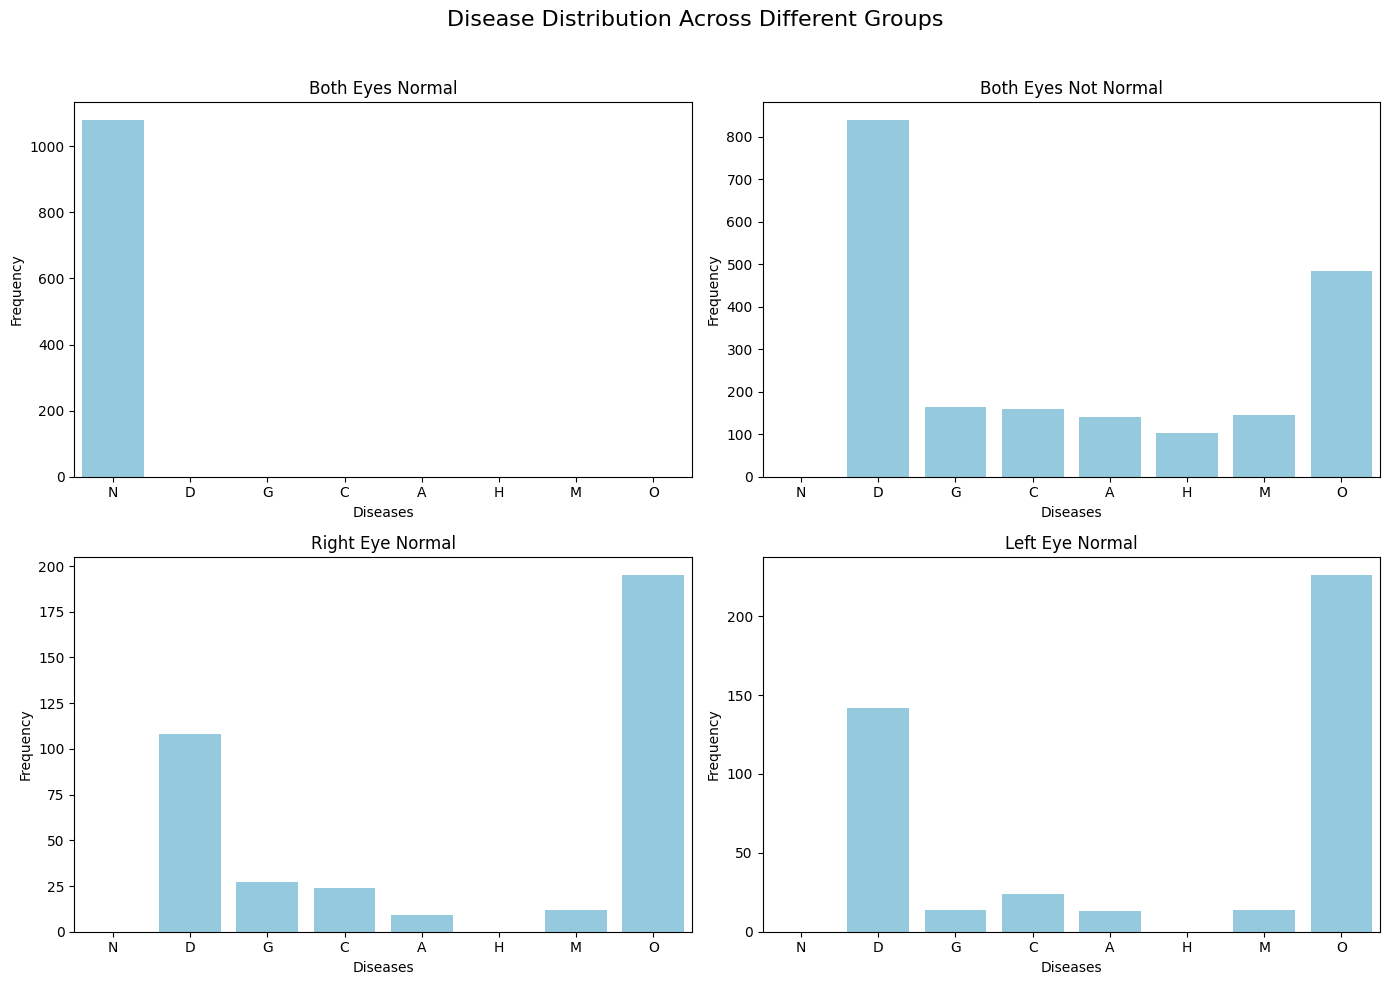

In [46]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Disease Distribution Across Different Groups', fontsize=16)

# Define titles for the subplots
titles = [
    'Both Eyes Normal',
    'Both Eyes Not Normal',
    'Right Eye Normal',
    'Left Eye Normal'
]

# Create a list of DataFrames
dataframes = [both_eyes_normal, both_eyes_not_normal, right_eye_normal, left_eye_normal]

# Loop through DataFrames and plot on subplots
for df, ax, title in zip(dataframes, axes.ravel(), titles):
    disease_columns = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
    disease_counts = df[disease_columns].sum()

    sns.barplot(x=disease_counts.index, y=disease_counts.values, color='skyblue', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Diseases')
    ax.set_ylabel('Frequency')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

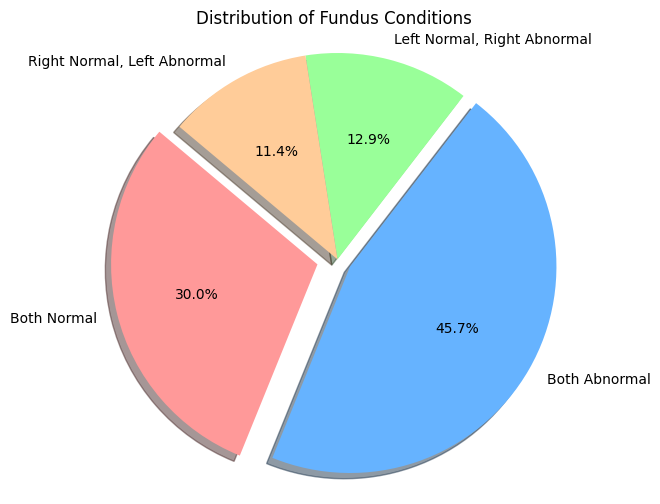

In [47]:
condition_normal_left = eyes['Left-Diagnostic Keywords'] == 'normal fundus'
condition_normal_right = eyes['Right-Diagnostic Keywords'] == 'normal fundus'

# Determine the categories
both_normal = (condition_normal_left) & (condition_normal_right)
both_abnormal = (~condition_normal_left) & (~condition_normal_right)
left_normal_right_abnormal = (condition_normal_left) & (~condition_normal_right)
right_normal_left_abnormal = (~condition_normal_left) & (condition_normal_right)

# Count occurrences for each category
counts = {
    'Both Normal': both_normal.sum(),
    'Both Abnormal': both_abnormal.sum(),
    'Left Normal, Right Abnormal': left_normal_right_abnormal.sum(),
    'Right Normal, Left Abnormal': right_normal_left_abnormal.sum()
}

# Create a pie chart
labels = counts.keys()
sizes = counts.values()
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
explode = (0.1, 0.07, 0, 0)  # explode the 1st slice (optional)

plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Distribution of Fundus Conditions')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Show the pie chart
plt.show()

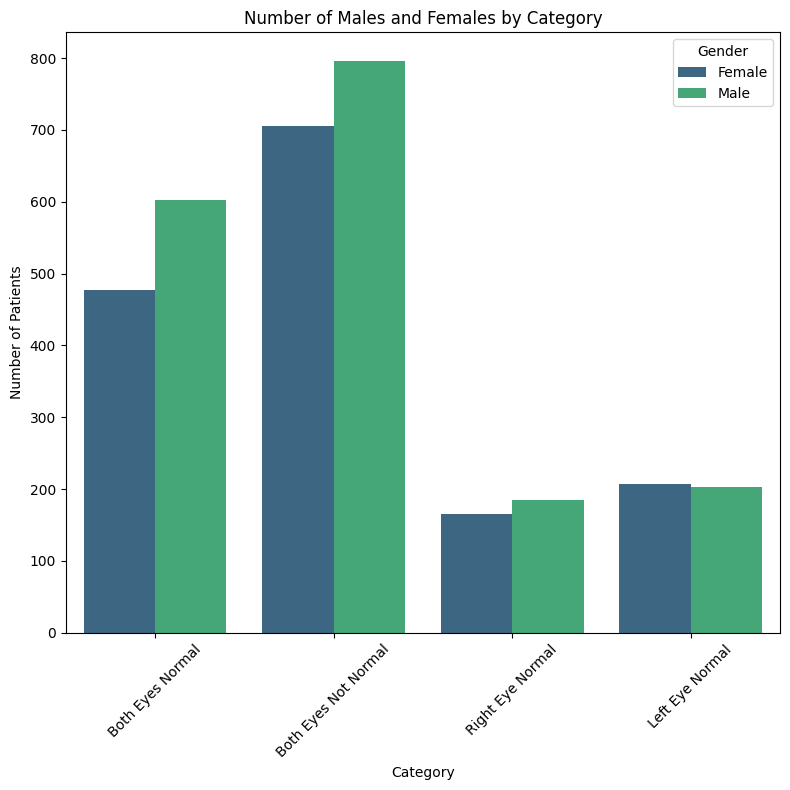

In [48]:
counts = {
    'Both Eyes Normal': both_eyes_normal['Patient Sex'].value_counts(),
    'Both Eyes Not Normal': both_eyes_not_normal['Patient Sex'].value_counts(),
    'Right Eye Normal': right_eye_normal['Patient Sex'].value_counts(),
    'Left Eye Normal': left_eye_normal['Patient Sex'].value_counts()
}

# Convert to DataFrame for easy plotting
plot_data = pd.DataFrame(counts).fillna(0).T.reset_index()
plot_data = plot_data.melt(id_vars='index', var_name='Gender', value_name='Count')
plot_data = plot_data.rename(columns={'index': 'Category'})

# Create the bar plot
plt.figure(figsize=(8, 8))
sns.barplot(data=plot_data, x='Category', y='Count', hue='Gender', palette='viridis')

plt.title('Number of Males and Females by Category')
plt.xlabel('Category')
plt.ylabel('Number of Patients')
plt.legend(title='Gender')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

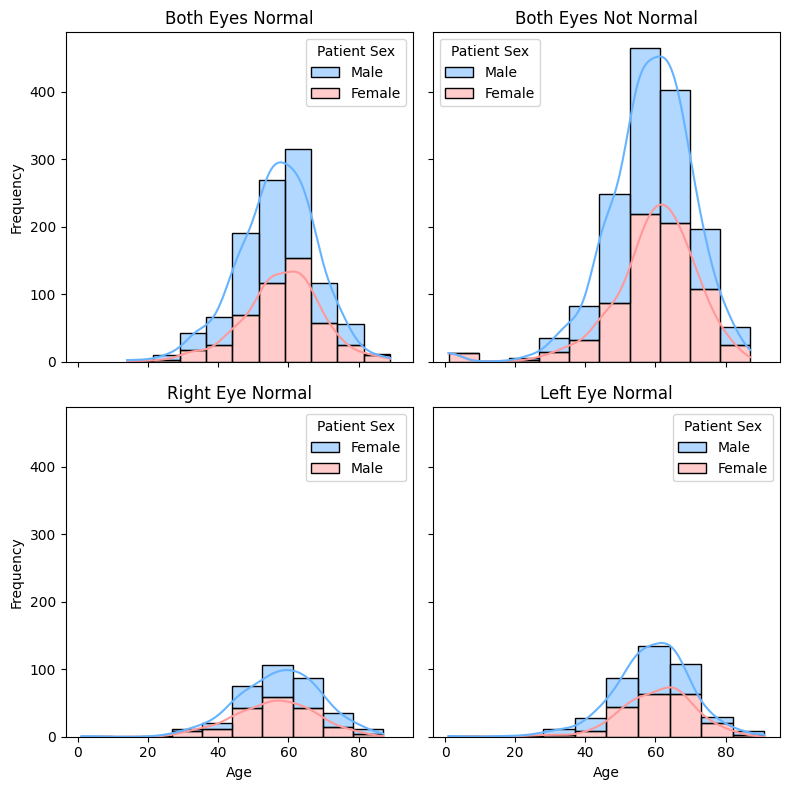

In [49]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)

dataframes = [both_eyes_normal, both_eyes_not_normal, right_eye_normal, left_eye_normal]
titles = ['Both Eyes Normal', 'Both Eyes Not Normal', 'Right Eye Normal', 'Left Eye Normal']
colors = ['#66b3ff', '#ff9999']

# Plot each dataframe
for i, (df, title) in enumerate(zip(dataframes, titles)):
    row = i // 2
    col = i % 2
    sns.histplot(df, x='Patient Age', hue='Patient Sex', multiple='stack', palette=colors, bins=10, ax=axes[row, col], kde=True)
    axes[row, col].set_title(title)
    axes[row, col].set_xlabel('Age')
    axes[row, col].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

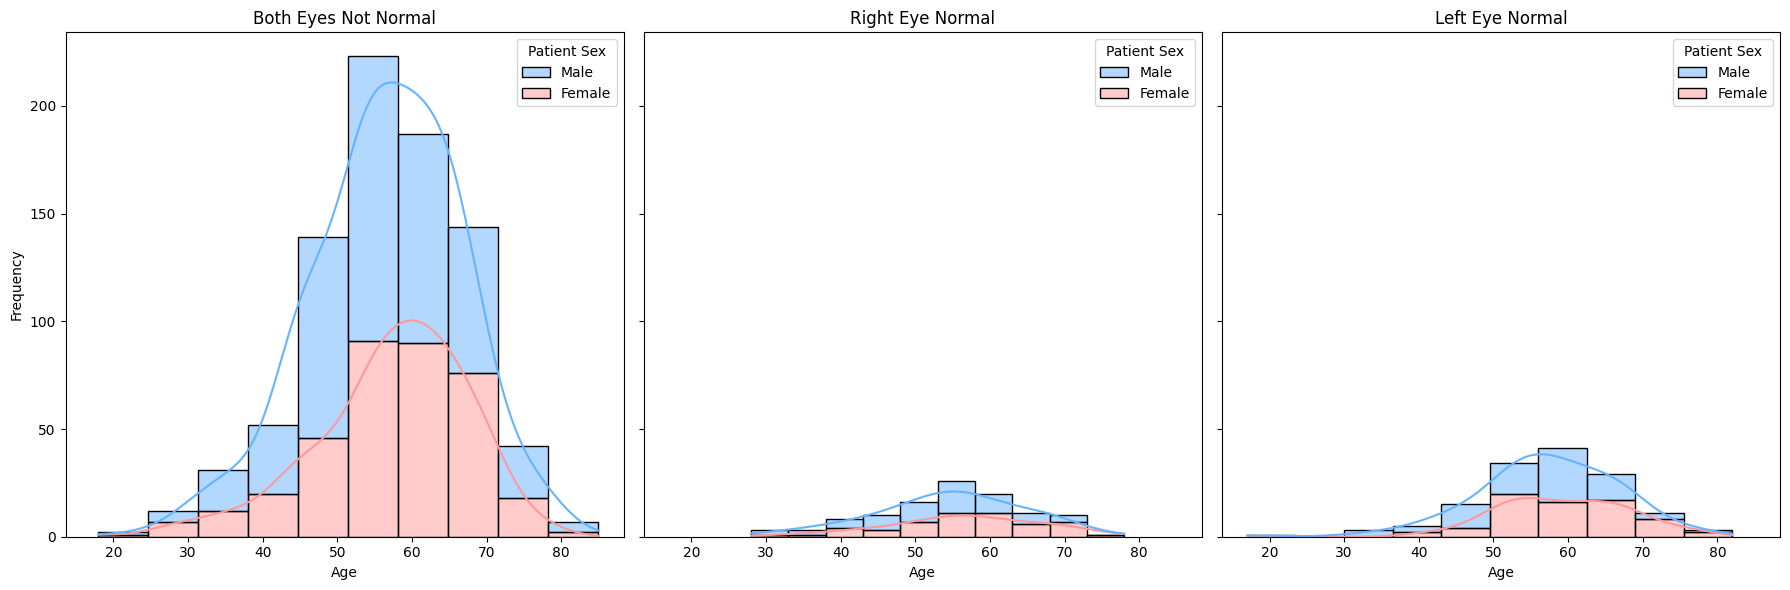

In [50]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

dataframes = [both_eyes_not_normal, right_eye_normal, left_eye_normal]

titles = ['Both Eyes Not Normal', 'Right Eye Normal', 'Left Eye Normal']
colors = ['#66b3ff', '#ff9999']

# Plot each dataframe with condition D = 1 applied within the loop
for i, (df, title) in enumerate(zip(dataframes, titles)):
    row = i // 3
    col = i % 3
    filtered_df = df.query('D == 1')
    if not filtered_df.empty:
        sns.histplot(filtered_df, x='Patient Age', hue='Patient Sex', multiple='stack', palette=colors, bins=10, ax=axes[col], kde=True)
    axes[col].set_title(title)
    axes[col].set_xlabel('Age')
    axes[col].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

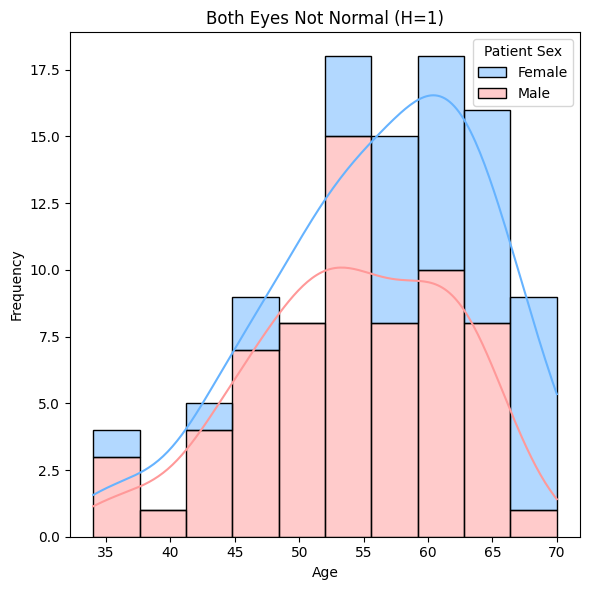

In [51]:
fig, ax = plt.subplots(figsize=(6, 6))

# Define the DataFrame and title
df = both_eyes_not_normal
title = 'Both Eyes Not Normal (H=1)'
colors = ['#66b3ff', '#ff9999']

# Filter data for H = 1 and plot
filtered_df = df.query('H == 1')
if not filtered_df.empty:
    sns.histplot(filtered_df, x='Patient Age', hue='Patient Sex', multiple='stack', palette=colors, bins=10, ax=ax, kde=True)
    ax.set_title(title)
    ax.set_xlabel('Age')
    ax.set_ylabel('Frequency')
else:
    ax.text(0.5, 0.5, 'No data available for H = 1', horizontalalignment='center', verticalalignment='center', fontsize=14, color='red')

# Adjust layout
plt.tight_layout()
plt.show()

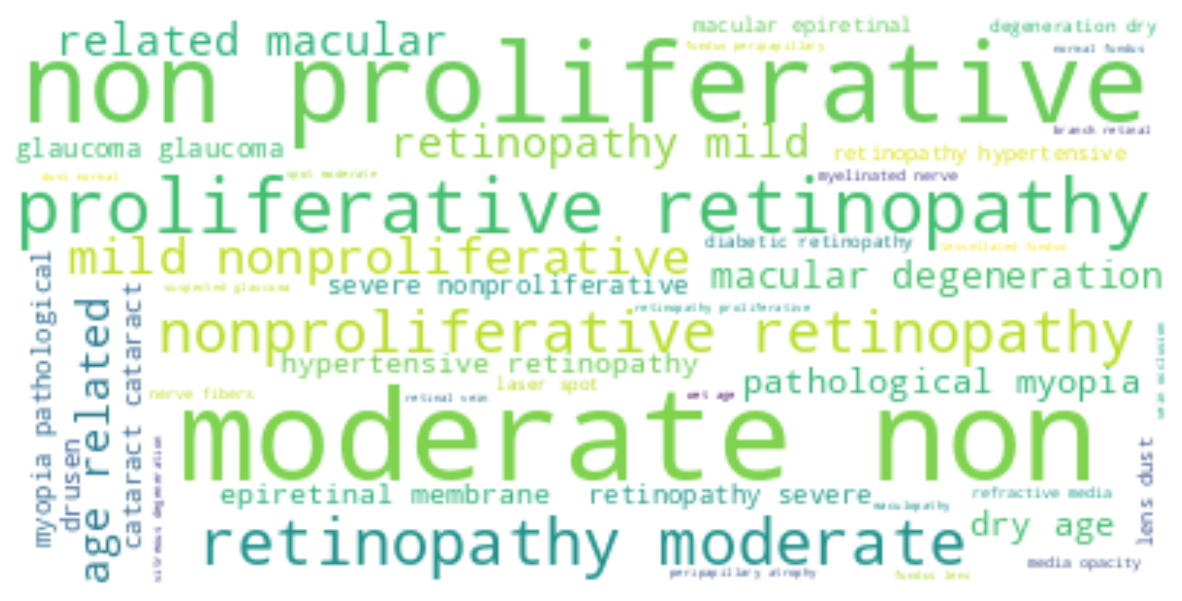

In [53]:
text = " ".join(i for i in both_eyes_not_normal['Right-Diagnostic Keywords'])
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

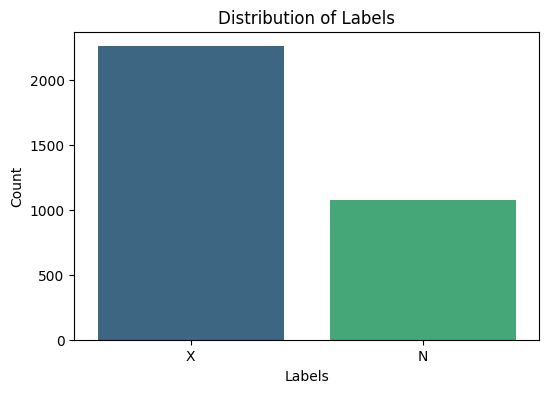

In [54]:
eyes.loc[eyes['labels'] != 'N', 'labels'] = 'X'

plt.figure(figsize=(6, 4))
sns.countplot(data=eyes, x='labels', hue='labels', palette='viridis')

plt.title('Distribution of Labels')
plt.xlabel('Labels')
plt.ylabel('Count')

plt.show()

Exctracting zip file

Loading Preprocessed Images


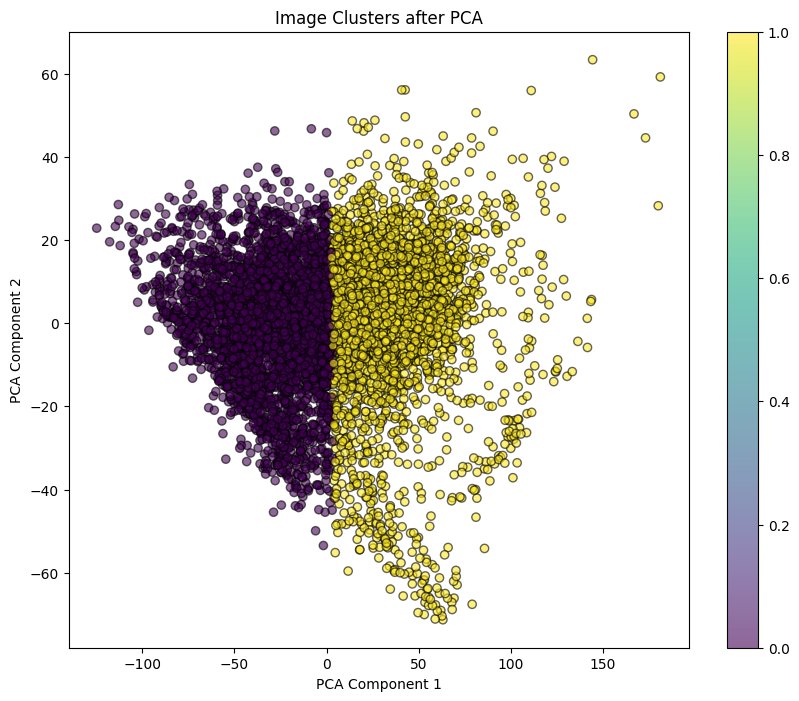

In [55]:
train_dir = "/content/drive/MyDrive/occular_disease_recognition_dataset"

file_paths = []
features = []

for root, dirs, files in os.walk(train_dir):
    for file in files:
        if file.endswith(('jpg', 'png', 'jpeg')):
            file_path = os.path.join(root, file)
            file_paths.append(file_path)

            image = cv2.imread(file_path)
            image = cv2.resize(image, (100, 100))
            avg_color = image.mean(axis=0).mean(axis=0)
            features.append(avg_color)

features = np.array(features)

pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features)

kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(reduced_features)

eyes = pd.DataFrame({
    'file_path': file_paths,
    'PCA1': reduced_features[:, 0],
    'PCA2': reduced_features[:, 1],
    'cluster': clusters
})

plt.figure(figsize=(10, 8))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=clusters, cmap='viridis', alpha=0.6, edgecolor='k')
plt.title("Image Clusters after PCA")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar()
plt.show()

In [56]:
eyes.head()


,file_path,PCA1,PCA2,cluster
0,/content/drive/MyDrive/occular_disease_recogni...,30.074073,7.626391,1
1,/content/drive/MyDrive/occular_disease_recogni...,17.570193,15.597780,1
2,/content/drive/MyDrive/occular_disease_recogni...,54.981205,-9.414761,1
3,/content/drive/MyDrive/occular_disease_recogni...,15.129897,9.373474,1
4,/content/drive/MyDrive/occular_disease_recogni...,55.367375,-24.715575,1


In [57]:
eyes['cluster'].value_counts()


,count
cluster,
0,3458
1,2934


In [58]:
eyes.drop(columns = ['PCA1' , 'PCA2'], axis=1 , inplace = True)


In [59]:
eyes['cluster'].value_counts()


,count
cluster,
0,3458
1,2934


In [60]:
eyes['cluster'] = eyes['cluster'].replace({0: 'X', 1: 'N'})


In [61]:
train_data, test = train_test_split(eyes, test_size=0.4, random_state=42, stratify=eyes['cluster'])
test, valid_data = train_test_split(test, test_size=0.5, random_state=42, stratify=test['cluster'])

print(f"Training set shape: {train_data.shape}")
print(f"Validation set shape: {valid_data.shape}")
print(f"Testing set shape: {test.shape}")

Training set shape: (3835, 2)
Validation set shape: (1279, 2)
Testing set shape: (1278, 2)


In [62]:
train_datagen = ImageDataGenerator(rescale=1./255 )

# Create an ImageDataGenerator for validation and test data (no data augmentation)
valid_test_datagen = ImageDataGenerator(rescale=1./255)

# Specify the input size expected by the model
input_size = (224, 224)

# Create data generators for training, validation, and testing
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    x_col='file_path',
    y_col='cluster',
    target_size=input_size,
    shuffle = True,
    batch_size=8,
    class_mode='categorical',
    color_mode = 'rgb'
)

valid_generator = valid_test_datagen.flow_from_dataframe(
    dataframe=valid_data,
    x_col='file_path',
    y_col='cluster',
     target_size=input_size,
    shuffle = True,
    batch_size=16,
    class_mode='categorical',
    color_mode = 'rgb'
)

test_generator = valid_test_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='file_path',
    y_col='cluster',
    target_size=input_size,
    shuffle=False,
    batch_size=16,
    class_mode='categorical',
    color_mode = 'rgb'
)

Found 3835 validated image filenames belonging to 2 classes.
Found 1279 validated image filenames belonging to 2 classes.
Found 1278 validated image filenames belonging to 2 classes.


In [63]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    x_col='file_path',
    y_col='cluster',
    target_size=input_size,
    shuffle = True,
    batch_size=8,  # Reduced batch size
    class_mode='categorical',
    color_mode = 'rgb'
)

valid_generator = valid_test_datagen.flow_from_dataframe(
    dataframe=valid_data,
    x_col='file_path',
    y_col='cluster',
     target_size=input_size,
    shuffle = True,
    batch_size=8,  # Reduced batch size
    class_mode='categorical',
    color_mode = 'rgb'
)

test_generator = valid_test_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='file_path',
    y_col='cluster',
    target_size=input_size,
    shuffle=False,
    batch_size=8,  # Reduced batch size
    class_mode='categorical',
    color_mode = 'rgb'
)

Found 3835 validated image filenames belonging to 2 classes.
Found 1279 validated image filenames belonging to 2 classes.
Found 1278 validated image filenames belonging to 2 classes.


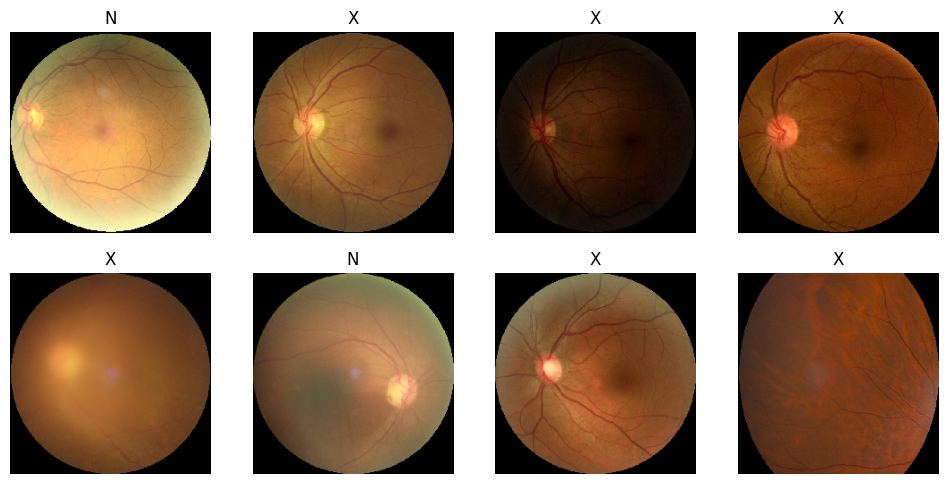

In [65]:
sample_images, sample_labels = next(train_generator)

# Display the images and labels
plt.figure(figsize=(12, 12))
for i in range(len(sample_images)): # Changed to iterate over the length of sample_images
    image = sample_images[i]
    label_index = np.argmax(sample_labels[i])
    label = list(train_generator.class_indices.keys())[label_index]

    plt.subplot(4, 4, i+1)
    plt.imshow(image)
    plt.title(label, color='k', fontsize=12)
    plt.axis("off")

plt.show()

In [66]:
input_shape = (224, 224, 3)

model = Sequential()
model.add(Conv2D(512, (3, 3), padding='same', input_shape=input_shape, activation='relu'))
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))

model.compile(optimizer=Adamax(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [67]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('brain_tumors/best_model.keras', save_best_only=True)

In [68]:
history = model.fit(train_generator, epochs=10, validation_data=valid_generator,
                    validation_steps = None , shuffle = False,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/10
480/480 ━━━━━━━━━━━━━━━━━━━━ 1085s 2s/step - accuracy: 0.7608 - loss: 1.3189 - val_accuracy: 0.9195 - val_loss: 0.2387
Epoch 2/10
480/480 ━━━━━━━━━━━━━━━━━━━━ 937s 2s/step - accuracy: 0.9309 - loss: 0.2263 - val_accuracy: 0.9382 - val_loss: 0.1851
Epoch 3/10
480/480 ━━━━━━━━━━━━━━━━━━━━ 920s 2s/step - accuracy: 0.9194 - loss: 0.1895 - val_accuracy: 0.8890 - val_loss: 0.2486
Epoch 4/10
480/480 ━━━━━━━━━━━━━━━━━━━━ 912s 2s/step - accuracy: 0.9297 - loss: 0.1921 - val_accuracy: 0.9140 - val_loss: 0.1859
Epoch 5/10
480/480 ━━━━━━━━━━━━━━━━━━━━ 911s 2s/step - accuracy: 0.9322 - loss: 0.1810 - val_accuracy: 0.9265 - val_loss: 0.1684
Epoch 6/10
480/480 ━━━━━━━━━━━━━━━━━━━━ 921s 2s/step - accuracy: 0.9451 - loss: 0.1533 - val_accuracy: 0.9382 - val_loss: 0.1507
Epoch 7/10
480/480 ━━━━━━━━━━━━━━━━━━━━ 905s 2s/step - accuracy: 0.9466 - loss: 0.1448 - val_accuracy: 0.9468 - val_loss: 0.1271
Epoch 8/10
480/480 ━━━━━━━━━━━━━━━━━━━━ 902s 2s/step - accuracy: 0.9502 - loss: 0.1367 - val_acc

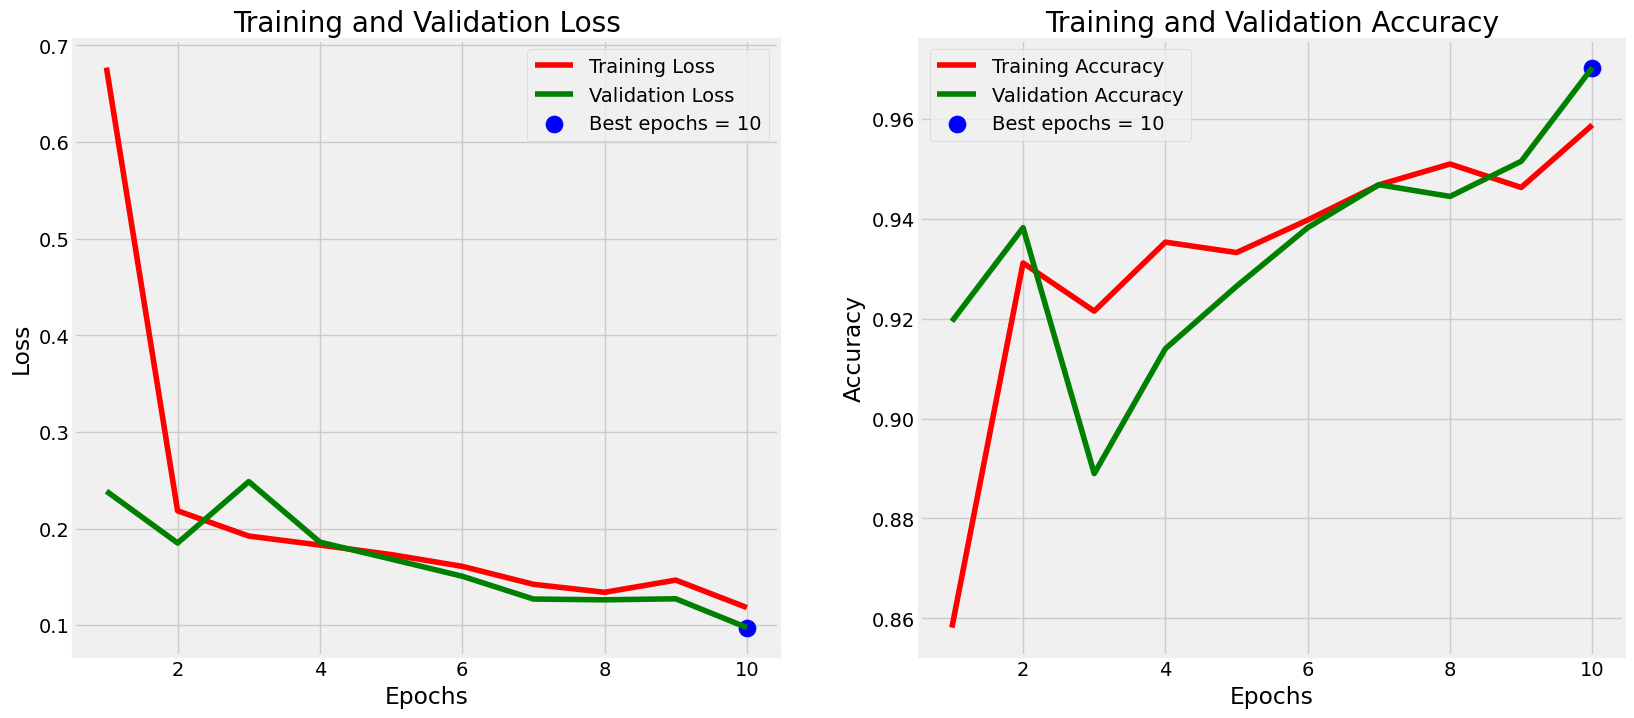

In [69]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best epochs = {str(index_loss +1)}'
acc_label = f'Best epochs = {str(index_acc + 1)}'

#Training history

plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'r' , label = 'Training Loss')
plt.plot(Epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'blue',label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'r' , label = 'Training Accuracy')
plt.plot(Epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s = 150 , c = 'blue',label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show();

In [71]:
# Evaluate the model on the training set
train_score = model.evaluate(train_generator)
print(f"Training Loss: {train_score[0]}, Training Accuracy: {train_score[1]}")

# Evaluate the model on the validation set
valid_score = model.evaluate(valid_generator)
print(f"Validation Loss: {valid_score[0]}, Validation Accuracy: {valid_score[1]}")

# Evaluate the model on the test set
test_score = model.evaluate(test_generator)
print(f"Test Loss: {test_score[0]}, Test Accuracy: {test_score[1]}")

480/480 ━━━━━━━━━━━━━━━━━━━━ 312s 650ms/step - accuracy: 0.9821 - loss: 0.0749
Training Loss: 0.0849926695227623, Training Accuracy: 0.9752281904220581
160/160 ━━━━━━━━━━━━━━━━━━━━ 100s 625ms/step - accuracy: 0.9679 - loss: 0.1032
Validation Loss: 0.09752592444419861, Validation Accuracy: 0.9702892899513245
160/160 ━━━━━━━━━━━━━━━━━━━━ 120s 750ms/step - accuracy: 0.9637 - loss: 0.0992
Test Loss: 0.09315861761569977, Test Accuracy: 0.9671361446380615


In [72]:
preds = model.predict(test_generator)

y_pred = np.argmax(preds, axis=1)

160/160 ━━━━━━━━━━━━━━━━━━━━ 100s 620ms/step


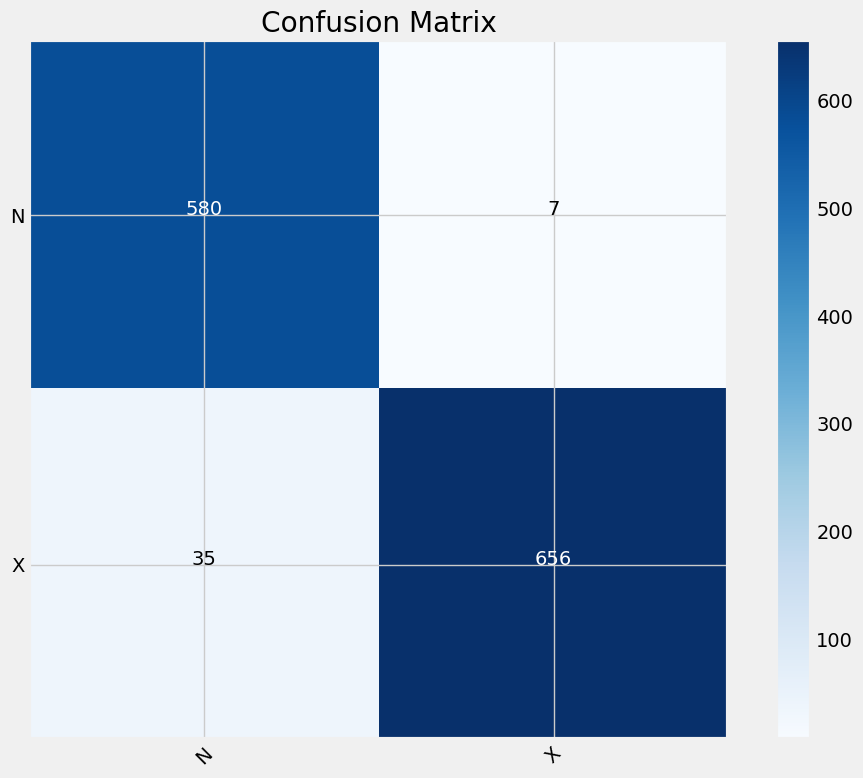

In [73]:
g_dict = test_generator.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_generator.classes, y_pred)

plt.figure(figsize= (10, 8))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()

plt.show()